In [1]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt

from Miniproject_2.model import *

import torch
from torch.nn import functional as F

torch.set_grad_enabled(True);

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

valid_input, valid_target = torch.load('../val_data.pkl',map_location=device)#validation set (noise-clean)
train_input, train_target = torch.load('../train_data.pkl',map_location=device) #test set (noise-noise)

# num_samples = 1000
# valid_input=torch.narrow(valid_input,0,0,num_samples)
# valid_target=torch.narrow(valid_target,0,0,num_samples)
# train_input=torch.narrow(train_input,0,0,num_samples)
# train_target=torch.narrow(train_target,0,0,num_samples)

# plt.imshow(valid_input[164].permute(1,2,0))

print("Vector shape: ",train_input.shape)

Vector shape:  torch.Size([50000, 3, 32, 32])


In [3]:
def compare(x,y,decimals=7):
    return torch.all(torch.round(torch.abs(x - y), decimals=decimals)==0.).item()

## Test MSE loss derivative

In [4]:
# Test MSE loss
idx = 164
len = 1
y=(valid_input[idx].float()/255.).requires_grad_()
y_true=(valid_target[idx].float()/255.).requires_grad_()

# fig,ax = plt.subplots(1,2, figsize=(8,8))
# ax[0].imshow(input.permute(1,2,0))
# ax[1].imshow(target.permute(1,2,0))
L = MSE()
out = L.forward(y,y_true)

L_true = F.mse_loss(y,y_true, reduction='mean')
print('Output: ', L_true, '\nTrue output: ', out)


Output:  tensor(0.0110, grad_fn=<MseLossBackward0>) 
True output:  0.011031925678253174


In [5]:
dL_dy = torch.autograd.grad(L_true,(y))[0]
dLdy = L.backward()

print(compare(dL_dy, dLdy, decimals=3))
print(dLdy.shape)

True
torch.Size([3, 32, 32])


## Test Sequential

### Declare filters

In [6]:
f = torch.empty(5,3,3,3)

f[0, 0] = torch.tensor([ [ +0., +0., -1. ], [ +0., +1., +0. ], [ -1., +0., +0. ]])
f[1, 0] = torch.tensor([ [ +1., +1., +1. ], [ +1., +1., +1. ], [ +1., +1., +1. ]])
f[2, 0] = torch.tensor([ [ -1., +0., +1. ], [ -1., +0., +1. ], [ -1., +0., +1. ]])
f[3, 0] = torch.tensor([ [ -1., -1., -1. ], [ +0., +0., +0. ], [ +1., +1., +1. ]])
f[4, 0] = torch.tensor([ [ +0., -1., +0. ], [ -1., +4., -1. ], [ +0., -1., +0. ]])

for j in range(0,5):
    for i in range(1,3):
        f[j,i] = f[j,0]

ff = f.transpose(0,1)
ff.requires_grad_();

### Declare layers and Sequential

In [7]:
stride = 2
kernel_size = 2

conv1 = Conv2d(3,5, kernel_size, stride=stride, padding=0, dilation=1)
# conv1.weight=f
relu1 = ReLU()
conv2 = Conv2d(5,5,kernel_size, stride=stride, padding=0, dilation=1)
relu2 = ReLU()
tconv3 = TransposeConv2d(5,5, kernel_size, stride=stride, padding=0, dilation=1)
relu3 = ReLU()
tconv4 = TransposeConv2d(5,3, kernel_size, stride=stride, padding=0, dilation=1)
sig4 = Sigmoid()

net = Sequential(conv1,  
                relu1,  
                conv2, 
                relu2, 
                tconv3,
                relu3, 
                tconv4,
                sig4
                )

In [8]:
idx    = 164
len    = 10
train_input  = valid_input[idx:idx+len].float()/255.
train_target = valid_target[idx:idx+len].float()/255.

In [9]:

eta = 0.1
batch_size = 2



for epoch in range(1):
    for x, trg in zip(train_input.split(batch_size), train_target.split(batch_size)):
        out = net(x)
        loss  = MSE()
        l_val = loss(out, trg)


        net.zero_grad()
        net.backward(loss.backward())
        for p in net.parameters():
            if p:
                p[0] = p[0] - eta * p[1]




In [10]:
out.shape

torch.Size([2, 3, 32, 32])

## Test Model

In [4]:
idx    = 165
len    = 45000
train_input  = valid_input[idx:idx+len].float()/255.
train_target = valid_target[idx:idx+len].float()/255.

### Train

In [5]:
mod = Model()

mod.train(train_input, train_target, 3 )

Completed: 2/2 

### Visual inspection

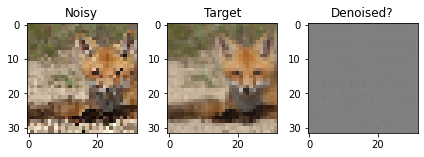

In [6]:
denoised = mod.predict(train_input[[idx]])

fig, ax = plt.subplots(nrows=1, ncols=3)

ax[0].imshow(train_input[idx].permute(1,2,0))
ax[1].imshow(train_target[idx].permute(1,2,0))
ax[2].imshow(denoised[0].permute(1,2,0))

ax[0].set_title('Noisy')
ax[1].set_title('Target')
ax[2].set_title('Denoised?')
fig.tight_layout()

## Test ```self.parameters```

In [14]:
stride = 2
kernel_size = 2

conv1 = Conv2d(3,5, kernel_size, stride=stride, padding=0, dilation=1)

In [15]:
net.param()


AttributeError: 'Sequential' object has no attribute 'param'